#LiveEo Data Science Challenge
###Author: Puneeth Kouloorkar
###Email: puneek95@zedat.fu-berlin.de

Sentinel-2 image data is given with one of the image with labels. There are 7 different classes in the labelled data marked with integers 0 to 6 referring to different objects (urban, treerow, forest, etc). 

To explore the dataset, rasterio library is used. The task is to train a classifier that recognizes the different labelled objects.

The follwing tasks are conducted in this order:



*   Exploring the dataset with rasterio
*   Finding the distribution of labels in the labelled image
*   Building the classifier and evaluating it on the test data
*   Conducting Chi-squared test to know the relation between each class

The S-2 images are obtained from: [S-2 images](https://drive.google.com/drive/folders/1wKu6fzz-cTZK22YBUqTa9o-u6HiT4-7h)
 and the labelled image is obtained from here: [Labelled image](https://drive.google.com/file/d/1YnLzVHauu1tRp5dWCd3VBScG4nCTVH1t/view)



Access to GPU in Colab - Colab is preferred here over Jupyter notebook to access the GPU:


In [ ]:
!nvidia-smi

Wed Jan 13 19:30:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |   2295MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Installing rasterio in colab:

In [ ]:
!pip install rasterio

Importing all the required libraries:

In [ ]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

### 1. Exploring S-2 satellite bands data:

1.1 Properties of one of the S-2 satellite bands. The bands are preprocessed already, so we can directly explore now:

In [ ]:
def dataset_explorer(path):
    with rasterio.open(path) as src:
        print(f"Width: {src.width}, Height: {src.height}")
        print(f"Coordinate Reference Systems: {src.crs}")
        print(f"Affine Transformation Matrix: {src.transform}")
        print(f"Number of bands: {src.count}")
        print(f"Indexes of bands: {src.indexes}")

path_S_2_data = '/content/drive/MyDrive/LiveEo/T17SLD_20190922T203454_AOT_10m.tif'
dataset_explorer(path_S_2_data)

Width: 10980, Height: 10980
Coordinate Reference Systems: EPSG:32617
Affine Transformation Matrix: | 10.00, 0.00, 300000.00|
| 0.00,-10.00, 4400040.00|
| 0.00, 0.00, 1.00|
Number of bands: 1
Indexes of bands: (1,)


1.2 As Rasterio reads raster data into numpy arrays, we can plot it with matplotlib:

In [ ]:
def raster_to_numpy(path):
    src = rasterio.open(path)
    array = src.read(1)     # The first band of the image is read and converted into numpy array
    return array

array = raster_to_numpy(path_S_2_data)
#plt.figure(figsize=(20,10))
#plt.imshow(array, cmap='pink')

1.3 Finding unique elements in **array** variable and also the frequency of unique elements:

In [ ]:
def unique_and_frequency(numpy_array):
    unique_elements, count_unique_elements = np.unique(np.ravel(numpy_array), return_counts=True)
    return unique_elements, count_unique_elements

unique_elements, count_unique_elements = unique_and_frequency(array)
print(unique_elements)
print(count_unique_elements)

[   68    69    70    71    72    73    74    75 65535]
[     1068    137384    230586       214       192       157        91
       551 120190157]


## 2. Exploring labelled data:

In [ ]:
path_labelled_data = '/content/drive/MyDrive/LiveEo/rasterize_on_sentinel_2_labelled_17SLD.tif'
dataset_explorer(path_labelled_data)

Width: 10980, Height: 10980
Coordinate Reference Systems: EPSG:32617
Affine Transformation Matrix: | 10.00, 0.00, 300000.00|
| 0.00,-10.00, 4400040.00|
| 0.00, 0.00, 1.00|
Number of bands: 2
Indexes of bands: (1, 2)


2.1 Plotting the first band (as required) using matplotlib

In [ ]:
array_labelled = raster_to_numpy(path_labelled_data)
#plt.figure(figsize=(20,10))
#plt.imshow(array_labelled, cmap='pink')

2.2 To check if all the elements are same in a numpy array:

In [ ]:
flatten_array_labelled = np.ravel(array_labelled)     # Converting the array into a vector
np.all(array_labelled==flatten_array_labelled[0])     # Checking if all the elements of the vector are same

False

2.3 Finding unique elements in **array_labelled** variable and also the frequency of unique elements:

In [ ]:
unique_elements_labelled, count_unique_elements_labelled = unique_and_frequency(flatten_array_labelled)
print(unique_elements_labelled)
print(count_unique_elements_labelled)

[         0          1          2          3          4          5
          6 4294967295]
[    19088      7188    153017       166     93879      7566     45487
 120234009]


2.3 Distribution of class labels in the labelled image (excluding element 4294967295):

<BarContainer object of 7 artists>

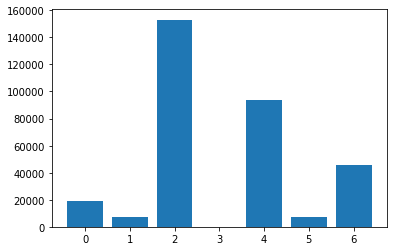

In [ ]:
plt.bar(unique_elements_labelled[:-1], height = count_unique_elements_labelled[:-1])     # PLotting a bar chart. The x-axis has the labels and y-axis is the frequency of labels.

### 3. Preprocessing of data before training:

3.1 As required, let's exclude the value 4294967295 from the data:
Previously the input matrix was of te dimension 10,980 x 10,980. After removing rows and columns with all the values as "4294967295" we end up with a smaller matrix of dimension 7324 x 6482.

In [ ]:
df = pd.DataFrame(array_labelled)     # Converting numpy array to a dataframe                          
df = df.replace(to_replace=4294967295, value=np.NaN)   # Replacing the element 4294967295 with NaN for easier pre-processing using Pandas Dataframes

In [ ]:
df = df.dropna(how='all', axis = 0)     # Removing all the rows with only NaN elements
df = df.dropna(how='all', axis = 1)     # Removing all the columns with only NaN elements
print(df)

       0      1      2      3      4      ...  10963  10964  10965  10966  10967
31       NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
32       NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
33       NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
34       NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
35       NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
...      ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
10959    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
10966    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
10967    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
10971    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
10976    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN

[7324 rows x 6482 columns]


3.2 Extract row and column indices of labels (given as pixel values):

In [ ]:
result = df[df >= 0].stack().index.tolist()     # Extracting the row and column indices of non-NaN elements
result = np.asarray(result)     # Converting the list to NumPy array

answer = df[df >= 0].stack().values.tolist()     # Extracting the labels from dataframe 
true_labels = np.array([int(value) for value in answer])     # Converting the labels from float to int

In [ ]:
X_1 = result[:,0]
X_2 = result[:,1]

df_final = pd.DataFrame({'X_1':X_1, 'X_2':X_2, 'Y':true_labels})     # Creating a dataframe with row indices, column indices and labels 
df_final.head()

,X_1,X_2,Y
0,31,10533,3
1,32,3154,0
2,32,3155,0
3,32,3156,0
4,32,3157,0


XG Boost is preferred here than other classiciation algorithms, as the label distribution reveals, we have an imbalanced dataset. So, boosting performs well with these type of datasets. 

Also there are lots of opportunities to further fine-tune the hyperparameters and model regularizers to obtain a good overall fitmet of the model.

In [ ]:
X, y = df_final.iloc[:,:2], df_final.iloc[:,2]     # X_1 and X_2 are put into one X to facilitate splitting of data into train and test
X.head()

,X_1,X_2
0,31,10533
1,32,3154
2,32,3155
3,32,3156
4,32,3157


3.3 Split the data into train and test:

In [ ]:
jdata_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=567)     # Splitting the data into 80% train and 20% test

unique_and_frequency(y_train)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 15246,   5763, 122274,    130,  75108,   6051,  36540]))

3.4 Build the XG Boost clssifier model:
Since we are working with a multi-class classification problem, we utilize the XGB Classifier model with a Softmax probability as the objective/loss function.

We use small L1 (Alpha) and L2 (Lambda) regularization penalty to force our model to assign equal model weights during training/prevent from larger weights getting accumulated. Also, L1 helps the model as a feature selector to achieve fine-tuned results.

In [ ]:
TREE_METHOD = 'gpu_hist'     # Training the model on GPU

xg_reg = xgb.XGBClassifier(tree_method = TREE_METHOD, objective ='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 20, alpha = 10, n_estimators = 10, reg_lambda = 5, reg_alpha = 10)     # Building the model with softmax output

3.5 Fit the model on the training data:

In [ ]:
xg_reg.fit(X_train,y_train)     # Fitting the model on the training data

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=10, reg_lambda=5, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

3.6 Predict the tet data with the trained model:

In [ ]:
preds = xg_reg.predict(X_test)     # Evaluating the trained model on testing data

Now we compute the overall model Accuracy and other evaluation metrics such as Precision, Recall, F1-measure (Micro & Macro).
Since we see that atleast some of the classes (eg: 3) are not very well populated when compared to their counterparts. Thus a Macro value of all the above mentioned metrics would be the right evaluation metric in this problem.

3.7 Calculate the overall accurcy, precision, recall and f-1 scores and plot the confusion matrix to look at the mislassifications in each class:

Overall accuracy of the model: 0.8546393173915041

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      3842
           1       0.88      0.25      0.40      1425
           2       0.87      0.94      0.90     30743
           3       0.00      0.00      0.00        36
           4       0.82      0.83      0.83     18771
           5       0.65      0.21      0.32      1515
           6       0.90      0.83      0.86      8947

    accuracy                           0.85     65279
   macro avg       0.71      0.55      0.59     65279
weighted avg       0.85      0.85      0.85     65279



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


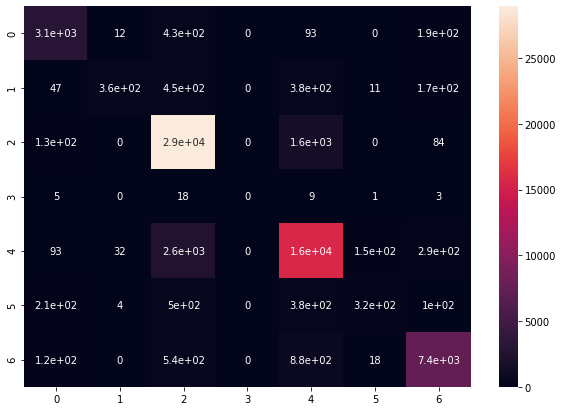

In [ ]:
print('Overall accuracy of the model: {}\n'.format(np.mean(preds == y_test.to_numpy())))     # Accuracy of classifications

classification_report_overall = classification_report(y_test, preds)     # Gives precision, recall and f-1 score
print(classification_report_overall)

cfn_mtx = confusion_matrix(y_test, preds)     # creating a confusion matrix of true labels and predicted labels
final_df = pd.DataFrame(cfn_mtx, range(7), range(7))     # Plotting the built confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(final_df, annot=True)

### 4. Statistical tests for relations between each class and each band of labelled image:

We use Chi-square statistical test because the variable 'true_labels' is a categorical variable with 7 categories (0 to 6) and this test returns two values: 1. chi square and 2. p value. We know that lower p-value means that we can reject the null hypothesis and indicate that there exists corelation between classes.

In [ ]:
chi_result = np.zeros([len(true_labels), 4])

for i in range(0, len(true_labels)-1):
    chi = chisquare(np.array([result[i, 0], result[i, 1]]), np.array([result[i+1, 0], result[i+1, 1]]))     # Chi-square test of the i^th and (i+1)^th row  
    chi_result[i,0] = true_labels[i]
    chi_result[i,1] = true_labels[i+1]
    chi_result[i,2] = chi[0]     # Chi² value
    chi_result[i,3] = chi[1]     # p value

# The first and second column of chi_result contains label values, third and fourth column contain corresponding chi-square and p values 

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:5745: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


4.1 "temp" matrix below is just created to be used in the next cell to plot corelation matrix

In [ ]:
temp = np.zeros([21,2])
temp[:6,1] = np.array([1,2,3,4,5,6])
temp[6:11,0], temp[6:11,1] = np.array([1,1,1,1,1]), np.array([2,3,4,5,6])
temp[11:15,0], temp[11:15,1] = np.array([2,2,2,2]), np.array([3,4,5,6])
temp[15:18,0], temp[15:18,1] = np.array([3,3,3]), np.array([4,5,6])
temp[18:20,0], temp[18:20,1] = np.array([4,4]), np.array([5,6])
temp[20,0], temp[20,1] = np.array([5]), np.array([6])
temp

array([[0., 1.],
       [0., 2.],
       [0., 3.],
       [0., 4.],
       [0., 5.],
       [0., 6.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [2., 3.],
       [2., 4.],
       [2., 5.],
       [2., 6.],
       [3., 4.],
       [3., 5.],
       [3., 6.],
       [4., 5.],
       [4., 6.],
       [5., 6.]])

4.2 Now that we have p values of pair of classes in "chi_result", now these p values of pair of classes (eg: 0 and 1 & also 1 and 0) are averaged to get the final p value between those pair of classes. 

In [ ]:
corel = np.zeros([6,6])

for j in range(temp.shape[0]):
    sum = 0
    count = 0
    for i in range(chi_result.shape[0]):
        if (chi_result[i,0] == temp[j,0] and chi_result[i,1] == temp[j,1]) or (chi_result[i,0] == temp[j,1] and chi_result[i,1] == temp[j,0]):
            sum += chi_result[i,-1]
            count += 1
    corel[int(temp[j,0]), int(temp[j,1])-1] = sum/count
    #print('p value between class {} and class {}: {}'.format(int(temp[j,0]), int(temp[j,1]), sum/count))

corel[corel==0]=np.nan     # Replace 0's with NaN's

df_corel = pd.DataFrame(corel)
df_corel.columns = ['1','2','3','4','5','6']

4.3 Let's look at the averaged p value between the classes in the form of a table. The index column has classes from 0 to 5 and column names are classes from 0 to 6. NaN represents that we already know the p value between those classes (eg: we know that the p value between class i and class i is 0 and between class i and class j, it's already computed as p value between class j and class i):

In [ ]:
df_corel     # Indices are classes from 0 to 5 and column names are classes from 0 to 6

,1,2,3,4,5,6
0,0.002157,0.093736,1.256884e-158,5.406213e-60,3.701754e-27,2.429364e-03
1,NaN,0.072322,1.121584e-01,3.525751e-01,1.680611e-01,6.252209e-02
2,NaN,NaN,1.876039e-01,2.396949e-01,3.112426e-01,5.067962e-04
3,NaN,NaN,NaN,2.121787e-01,4.187521e-01,6.764974e-03
4,NaN,NaN,NaN,NaN,2.053240e-01,1.841785e-02
5,NaN,NaN,NaN,NaN,NaN,7.682067e-11


4.4 Pearson's test to relate the two bands of the labelled image. We can see that the two arrays (array of band 1 and band 2) are positively correlated and that the correlation is 0.999999. This suggests a high level of correlation.

In [ ]:
array_labelled_data = rasterio.open('/content/drive/MyDrive/LiveEo/rasterize_on_sentinel_2_labelled_17SLD.tif')
array_band_1 = array_labelled_data.read(1)
array_band_2 = array_labelled_data.read(2)
pear = pearsonr(np.ravel(array_band_1), np.ravel(array_band_2))
print(pear)  

(0.9999999999330815, 0.0)
